In [1]:
%matplotlib inline

import os
import sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# pre-process

In [2]:
# pre-processing
def pp_labs(labs, ed_redo, time_interval=240):
    """Function to preprocess labs.
    
    Steps:
        1. selects labs of base cohort through join
        2. replaces non-numerical values
        3. filters based on time interval
        4. selects first value within filtered time interval
        5. pivots lab types into columns

    Parameters:
        labs: dataframe of labs
        base: dataframe of base cohort
        time_interval: time interval/window to be chosen from ed arrival to lab measurement
    
    Returns: 
        dataframe: a dataframe with each lab in a column as numerical type
    """
    print('Pre-processing labs')
    tic = time.time()
    # join with base cohort
    if False:
        # don't join, do separately later in merge_pp()
        #labs = labs.merge(base, how='inner', on='visit_occurrence_id') 
        labs = sparkjson.toPandas() # adjust arg if PySpark starting pt 
        
    labs = labs.merge(ed_redo.loc[:,['visit_occurrence_id','ArrivalInstant']], 
                  left_on='visit_occurrence_id',right_on='visit_occurrence_id',how='left') # carries around NaN in ArrivalInstant, assumed fixed on ed_extra inner join with outcomes
    labs = labs.rename(columns={'ArrivalInstant':'ed_arrival_datetime'})
        
    # select relevant columns 
    
    
    labs = labs[['lab_name',
                 'ed_arrival_datetime',
                 'measurement_datetime',
                 'value_source_value',
                 'visit_occurrence_id']]
    
    # replace non-numeric characters with "" for values
    labs['value_source_value'] = labs['value_source_value'].str.replace('[^\d.]+', '')
    
    # change datetime types
    labs['ed_arrival_datetime'] = pd.to_datetime(labs['ed_arrival_datetime'])
    labs['measurement_datetime'] = pd.to_datetime(labs['measurement_datetime'])
    
    # ArrivalInstant in GMT, so offset by 5h
    labs['ed_arrival_datetime'] = labs['ed_arrival_datetime'] + pd.offsets.Hour(5)
    
    # create variable for time interval
    labs['time_diff'] = (labs['measurement_datetime']-labs['ed_arrival_datetime']).astype('timedelta64[m]')
    
    #get distinct values
    labs = labs.drop_duplicates(subset=('lab_name',
                                        'measurement_datetime',
                                        'visit_occurrence_id'))
    
    #filter labs base on time window
    labs = labs[labs['time_diff']<time_interval]
    
#     #group by lab_name and visit_occurrence_id and get first value
    labs = labs[['lab_name', 'visit_occurrence_id', 'value_source_value']]
    labs = (labs
          .groupby(['visit_occurrence_id', 'lab_name'], as_index=False)
          .aggregate(lambda x: list(x)[0]))
    
    #pivot data
    labs = labs.pivot(index='visit_occurrence_id',
                      columns = 'lab_name',
                      values='value_source_value')
    
    for i in labs.columns:
        labs.loc[:,i] = pd.to_numeric(labs.loc[:,i], errors='raise')
    print('  processed in {:.2f}-s'.format(time.time()-tic))
    return labs



def add_header(outcomes, outcomes_header):
    """Put header on outcomes file.
    
    Parameters:
        outcomes: sparkjson obj of outcomes
        outcomes_header: sparkjson obj of outcomes_header

    Returns: 
        dataframe: a dataframe of outcomes with appropriate header
    """
    # note:  csn is included in header but not in outcomes file
    if False:
        # coming 
        outcomes = outcomes.toPandas()
        outcomes_header = outcomes_header.toPandas()
    
    outcomes.columns=outcomes_header.values.tolist()[0][0:15]
    
    return outcomes

def resp_status240(outcomes):
    #processing for < time interval
    #select outcome columns
    outcome_columns = ['HIGH_FLOW', 'INVASIVE', 'LOW_FLOW', 'NON_INVASIVE', 'ROOM_AIR', 'death']
    temp = outcomes[['visit_occurrence_id'] + outcome_columns]
    #replace all values greater than 240
    temp[outcome_columns] = temp[outcome_columns].where(temp[outcome_columns] <240, np.NaN)
    temp['max'] = temp[outcome_columns].max(axis=1)
    temp['ox_status240'] = np.select(
        [
            (temp['HIGH_FLOW']==temp['max']),
            (temp['INVASIVE']==temp['max']),
            (temp['NON_INVASIVE']==temp['max']),
            (temp['LOW_FLOW']==temp['max']),
            (temp['ROOM_AIR']==temp['max']),
            (temp['death']==temp['max']) 
        ],
        [
            'HIGH_FLOW',
            'INVASIVE',
            'NON_INVASIVE',
            'LOW_FLOW',
            'ROOM_AIR',
            'death'
        ],
        default='UNKNOWN'
    )
    temp = temp[['visit_occurrence_id', 'max', 'ox_status240']]
    outcomes = outcomes.merge(temp) 
    #processing for geater than time interval
    temp = outcomes[['visit_occurrence_id'] + outcome_columns]
    temp[outcome_columns] = temp[outcome_columns].where(temp[outcome_columns] >240, np.NaN)
    temp['min'] = temp[outcome_columns].min(axis=1)
    temp['ox_status_min_greater240'] = np.select(
        [
            (temp['HIGH_FLOW']==temp['min']),
            (temp['INVASIVE']==temp['min']),
            (temp['NON_INVASIVE']==temp['min']),
            (temp['LOW_FLOW']==temp['min']),
            (temp['ROOM_AIR']==temp['min']),
            (temp['death']==temp['min']) 
        ],
        [
            'HIGH_FLOW',
            'INVASIVE',
            'NON_INVASIVE',
            'LOW_FLOW',
            'ROOM_AIR',
            'death'
        ],
        default='UNKNOWN'
    )
    temp = temp[['visit_occurrence_id', 'min', 'ox_status_min_greater240']]    
    outcomes = outcomes.merge(temp) 
    # replace values if NaN before 240 with minimal value after
    outcomes['ox_status240'] = np.select(
        [
            (outcomes['ox_status240']=='UNKNOWN')
        ],
        [
            outcomes['ox_status_min_greater240']
        ],
        default=outcomes['ox_status240']
    )    
    outcomes['ox_status_min_greater240'] = np.select(
        [
            ((outcomes['ox_status_min_greater240']=='UNKNOWN')
             & (outcomes['ox_status240']=='ROOM_AIR'))
        ],
        [
           'ROOM_AIR'
        ],
        default=outcomes['ox_status_min_greater240']
    ) 
    # create variable for icu status
    outcomes['icu_status'] = np.select(
        [
            outcomes['icu_admit_instant'] < 240,
            outcomes['icu_admit_instant'] > 240
        ],
        [
            'icu_less_240',
            'icu_greater_240'
        ],
        default='no_icu'
    )
    outcomes['exclude_yn'] = np.select(
        [
            outcomes['icu_status']=='icu_less_240',
            outcomes['ox_status240'].isin(['UNKNOWN', 'HIGH_FLOW', 'INVASIVE', 'NON_INVASIVE', 'death'])
        ],
        [
            1,
            1,
        ],
        default=0
    )
    
    outcomes['exclude2_yn'] = np.select(
        [
            outcomes['icu_status']=='icu_less_240',
            outcomes['ox_status240'].isin(['UNKNOWN', 'HIGH_FLOW', 'INVASIVE', 'NON_INVASIVE', 'death']),
            outcomes['HIGH_FLOW']<240,
        ],
        [
            1,
            1,
            1
        ],
        default=0
    )
    return outcomes

def pp_outcomes(outcomes, ex_time_interval=240, outcome_time_interval=1440):
    """ Processes outcomes into final form
    
    Steps:
        1. Create variables(timestamp, timediff) for first critical illness state
        2. Create exclusion flag based on critical illness state < 4 hours
        3. Replace timestamps with timediff values
        4. 
        
    Parameters:
        outcomes (pd.DataFrame): pre-processed
        
    Returns: 
        dataframe: a pandas dataframe of outcomes
        creates two new variables
        'primary_yn' : primary outcome
        'exflag_yn' : flag for exclusion if outcome occurred within first 4 hours
        
    Assumptions:  
        if no timestamp for any o2 device assume room air
    """
        
    #restrict to outcomes with visit occurrence ids and reset type
    outcomes = outcomes.dropna(subset=['visit_occurrence_id'])
    outcomes['visit_occurrence_id'] = outcomes['visit_occurrence_id'].astype('int64')
    #subset data to only needed variables
    #create death timestamp (if discharge is expired replace with visit_end_datetime)
    outcomes['death'] = (np.select(
    [
      outcomes['discharge_to_source_value']=='Expired'
    ],
    [
      outcomes['visit_end_datetime']
    ],
    default=None)
    )
    #subset data to only needed variables 
    outcomes = outcomes.drop(['person_id',
                            'order_ts',
                            'received_ts',
                            'resulted_ts',
                            'result',
                            'discharge_to_source_value'], axis=1) 
    # drop visit end datetime
    outcomes = outcomes.drop(['visit_end_datetime'], axis=1)
    # gather data
    outcomes = pd.melt(outcomes, id_vars=['visit_occurrence_id', 'visit_start_datetime'])
    outcomes = outcomes.dropna()
    outcomes['visit_start_datetime'] = pd.to_datetime(outcomes['visit_start_datetime'])
    outcomes['value'] = pd.to_datetime(outcomes['value'], errors='coerce')
    # create variable for time interval
    outcomes['time_diff'] =(outcomes['value']-outcomes['visit_start_datetime']).astype('timedelta64[m]')
    outcomes = outcomes.pivot(index='visit_occurrence_id',
                    columns = 'variable',
                    values='time_diff')
    outcomes['exflag_yn'] = (np.select(
    [
      ((outcomes['HIGH_FLOW'] < ex_time_interval)
       & (pd.isna(outcomes['LOW_FLOW'])) 
       & (pd.isna(outcomes['ROOM_AIR']))
       ),
      ((outcomes['NON_INVASIVE'] < ex_time_interval) 
       & (pd.isna(outcomes['LOW_FLOW'])) 
       & (pd.isna(outcomes['ROOM_AIR']))
       ),
      ((outcomes['INVASIVE'] < ex_time_interval) 
       & (pd.isna(outcomes['LOW_FLOW'])) 
       & (pd.isna(outcomes['ROOM_AIR']))
       ),
      ((outcomes['death'] < ex_time_interval) 
       & (pd.isna(outcomes['LOW_FLOW'])) 
       & (pd.isna(outcomes['ROOM_AIR']))
       ),
      ((outcomes['HIGH_FLOW'] < ex_time_interval)
       & ((outcomes['HIGH_FLOW'] > outcomes['LOW_FLOW']) 
       | (outcomes['HIGH_FLOW'] > outcomes['ROOM_AIR']))
       ),
      ((outcomes['NON_INVASIVE'] < ex_time_interval) 
       & ((outcomes['NON_INVASIVE'] > outcomes['LOW_FLOW']) 
       | (outcomes['NON_INVASIVE'] > outcomes['ROOM_AIR']))
       ),
      ((outcomes['INVASIVE'] < ex_time_interval) 
       & ((outcomes['INVASIVE'] > outcomes['LOW_FLOW']) 
       | (outcomes['INVASIVE'] > outcomes['ROOM_AIR']))
       ),
      ((outcomes['death'] < ex_time_interval) 
       & ((outcomes['death'] > outcomes['LOW_FLOW']) 
       | (outcomes['death'] > outcomes['ROOM_AIR']))
       )
    ],
    [
      1,
      1,
      1,
      1,
      1,
      1,
      1,
      1,
    ],
    default=0)
    ) 
    outcomes['primary_outcome_yn'] = (np.select(
    [
      outcomes['HIGH_FLOW'] < outcome_time_interval,
      outcomes['NON_INVASIVE'] < outcome_time_interval,
      outcomes['INVASIVE'] < outcome_time_interval,
      outcomes['death'] < outcome_time_interval
    ],
    [
      1,
      1,
      1,
      1,
    ],
    default=0)
    )
    
    #unstack and reset index
    outcomes = outcomes.reset_index()
    
    return outcomes



def pp_ed_extra(ed):
    """Process file shared by AT.
    
    Replaces race and ethnicity categories, which were originally
    stored in demographics. Leaves site info hanging around.
    
    Arguments:
        ed (pd.DataFrame): loaded from csv
    
    Returns:
        pd.DataFrame
        
    """
    
    ed = ed.reset_index()
    ed = ed.rename(columns={'Name':'chief_complaint'})
    
    
    # drop duplicates in ed_extra on visit occureence
    ed = ed.drop_duplicates(subset='visit_occurrence_id') # NOTE: this may drop heterogeneity in 'chief_complaint'
    
    # replacements
    ed['AcuityLevel'].fillna('Unknown', inplace=True)
    ed['AcuityLevel'].replace('*Unspecified', 'Unknown')
    
    # datetime
    ed['ArrivalInstant'] = pd.to_datetime(ed['ArrivalInstant'])
    ed['DepartureInstant'] = pd.to_datetime(ed['DepartureInstant'])
    
    for category in ed['FinancialClass'].unique():
        if category=='Medicaid Managed Care':
            ed['FinancialClass'].replace(category, 'Medicaid', inplace=True)
        elif category=='Medicare Managed Care':
            ed['FinancialClass'].replace(category, 'Medicare', inplace=True)
        elif category=='Managed Care':
            ed['FinancialClass'].replace(category, 'Other', inplace=True)
        elif category=='BCBS':
            ed['FinancialClass'].replace(category, 'Commercial', inplace=True)
        elif 'Worker' in category:
            ed['FinancialClass'].replace(category, 'Other', inplace=True)
        ed['FinancialClass'].fillna('Unknown', inplace=True)
        
        for category in ed['PreferredLanguage'].unique():
            if category=='*Unspecified':
                ed['PreferredLanguage'].replace(category, 'Unknown', inplace=True)
            elif category=='English' or category=='Unknown':
                continue
            else:
                ed['PreferredLanguage'].replace(category, 'NotEnglish', inplace=True)
        ed['PreferredLanguage'].fillna('Unknown', inplace=True)
        
        ed['SmokingStatus'].replace('Never Assessed', 'Unknown', inplace=True)
        ed['SmokingStatus'].replace('Never Smoker ', 'Never Smoker', inplace=True)
        ed['SmokingStatus'].replace('*Unknown', 'Unknown', inplace=True)
        ed['SmokingStatus'].replace('Unknown If Ever Smoked', 'Unknown', inplace=True)
        ed['SmokingStatus'].fillna('Unknown', inplace=True)
        
        # top 10 complaints
        for i in ed['chief_complaint'].unique():
            if 'FEVER' in i:
                ed['chief_complaint'].replace(i, 'FEVER', inplace=True)
        top10 = ed.groupby('chief_complaint').count().sort_values(['FinancialClass'], ascending=False).iloc[0:10,:].index.to_list()
        
        for i in ed['chief_complaint'].unique():
            if i in top10:
                continue
            else:
                ed['chief_complaint'].replace(i, 'Other', inplace=True)
                
        # recode ethnicity NA to unknown 
        ed['Ethnicity'].fillna('Unknown', inplace=True)
        ed['Ethnicity'].replace('No matching concept', 'Unknown', inplace=True)
        
        # recod race to NA -> unknown and 4 categories 
        ed['FirstRace'].replace('Asian', 'Other', inplace=True)
        ed['FirstRace'].replace('American Indian or Alaska Native', 'Other', inplace=True)
        ed['FirstRace'].replace('No matching concept', 'Unknown', inplace=True)
        ed['FirstRace'].replace('Other Race', 'Other', inplace=True)
        ed['FirstRace'].replace('Race not stated', 'Unknown', inplace=True)
        ed['FirstRace'].replace('Native Hawaiian or Other Pacific Islander', 'Other', inplace=True)
        ed['FirstRace'].fillna('Unknown', inplace=True)
    
    
    return ed


def load_csv(filename):
    """Load data stored in csv files. 
    
    Returns:
        pd.DataFrame
    """
    return pd.read_csv(filename, index_col=0)

def pp_vitals(df,ed_redo, verbose=False):
    """Pre-process vitals dataframe
    
    Adds two features (Mean Arterial Pressure and Heart Index) and
    takes min max median first and last vitals measurement per 
    visit_occurence_id
    
    Arguments:
        df (pd.DataFrame): vitals df loaded from `load_vitals()`
        ed_redo (pd.DataFrame): grab the load_csv(ed_extra_final_redo.csv) file to get
            ArrivalInstant, match it with vitals visit_occurrence_id, and use it
            as the ed_arrival_datetime to keep only vitals measured within 4h ED arrival
        
    Returns:
        pd.DataFrame: pre-processed vitals, ready for integration
        
    """
    print('Pre-processing vitals')
    tic = time.time()
    
    if verbose:
        print('\n    Tracking SBP measurements, metric: %-NA')
        print('    before ed_extra merge')
#         pNA = 100*df['value_source_value'].isna().sum()/df.shape[0]
#         print('        {:.2f} %-NA'.format(pNA))
        pNA = 100*df.loc[df['vital_name']=='SBP','value_source_value'].isna().sum()/(df['vital_name']=='SBP').sum()
        print('        {:.2f} %-NA'.format(pNA))
    
    # add ed_arrival_datetime from outcomes
    df = df.merge(ed_redo.loc[:,['visit_occurrence_id','ArrivalInstant']], 
                  left_on='visit_occurrence_id',right_on='visit_occurrence_id',how='left') # carries around NaN in ArrivalInstant, assumed fixed on ed_extra inner join with outcomes
    
    if verbose:
        print('    after ed_extra merge')
#         pNA = 100*df['value_source_value'].isna().sum()/df.shape[0]
#         print('        {:.2f} %-NA'.format(pNA))
        pNA = 100*df.loc[df['vital_name']=='SBP','value_source_value'].isna().sum()/(df['vital_name']=='SBP').sum()
        print('        {:.2f} %-NA'.format(pNA))
    
    df = df.rename(columns={'ArrivalInstant':'ed_arrival_datetime'})
    
    
    
    df = df.dropna(subset=['visit_occurrence_id'])
    
    if verbose:
        print('    after dropping nas in visit_occurrence_id ')
#         pNA = 100*df['value_source_value'].isna().sum()/df.shape[0]
#         print('        {:.2f} %-NA'.format(pNA))
        pNA = 100*df.loc[df['vital_name']=='SBP','value_source_value'].isna().sum()/(df['vital_name']=='SBP').sum()
        print('        {:.2f} %-NA'.format(pNA))
    
    df['ed_arrival_datetime'] = pd.to_datetime(df['ed_arrival_datetime'])
    df['measurement_datetime'] = pd.to_datetime(df['measurement_datetime'])
    
    # ArrivalInstant in GMT, so offset by 5h
    df['ed_arrival_datetime'] = df['ed_arrival_datetime'] + pd.offsets.Hour(5)
    
    df['visit_occurrence_id'] = df['visit_occurrence_id'].astype('int64')
    
    # drop complete duplicates
    df = df.drop_duplicates()
    
        
        # NOTE: 
        ## x.duplicated().sum() != 0 # because some vitals get measured at the same time
    
    
    # drop vial if >4h after ed_arrival_datetime
    df['time_diff'] =(df['measurement_datetime']-df['ed_arrival_datetime']).astype('timedelta64[h]')
    df = df.loc[df['time_diff']<=4,:]
    df = df.drop(columns='time_diff')
    
    if verbose:
        print('    after time_diff gate')
#         pNA = 100*df['value_source_value'].isna().sum()/df.shape[0]
#         print('        {:.2f} %-NA'.format(pNA))
        pNA = 100*df.loc[df['vital_name']=='SBP','value_source_value'].isna().sum()/(df['vital_name']=='SBP').sum()
        print('        {:.2f} %-NA'.format(pNA))
    
    if False:
        # tweak this, it causes huge amounts of errors and nans
        df['value_source_value'] = df['value_source_value'].str.replace('[^\d.]+', '')
    df['value_source_value'] = pd.to_numeric(df['value_source_value'], errors='coerce')
    
    if verbose:
        print('    after numeric conversion')
#         pNA = 100*df['value_source_value'].isna().sum()/df.shape[0]
#         print('        {:.2f} %-NA'.format(pNA))
        pNA = 100*df.loc[df['vital_name']=='SBP','value_source_value'].isna().sum()/(df['vital_name']=='SBP').sum()
        print('        {:.2f} %-NA'.format(pNA))
    
    
    # long --> wide, filter values across rows, wide --> long
    x = df.pivot_table(index=['visit_occurrence_id','measurement_datetime'],
                       columns='vital_name',values='value_source_value')

    if verbose:
        print('    before physiological gates')
        pNA = 100*x.loc[:,'SBP'].isna().sum()/x.shape[0]
        print('        {:.2f} %-NA'.format(pNA))
        
        
    # filter physiological values
    ## SBP >300 or <30 
    x.loc[(x.loc[:,'SBP']<30) | 
          (x.loc[:,'SBP']>300),'SBP']=np.nan
    ## DBP >200 or <20 
    x.loc[(x.loc[:,'DBP']<20) | 
          (x.loc[:,'DBP']>200),'DBP']=np.nan
    ## HR >300 or <20 
    x.loc[(x.loc[:,'HR']<20) | 
          (x.loc[:,'HR']>300),'HR']=np.nan
    ## RR >60 or <5 
    x.loc[(x.loc[:,'RR']<5) | 
          (x.loc[:,'RR']>60),'RR']=np.nan
    ## SpO2 >100 or <40 
    x.loc[(x.loc[:,'SPO2']<40) | 
          (x.loc[:,'SPO2']>100),'SPO2']=np.nan
    ## Temp >106 or <80 
    x.loc[(x.loc[:,'TEMP']<80) | 
          (x.loc[:,'TEMP']>106),'TEMP']=np.nan
    ## BMI <10 or >80 
    x.loc[(x.loc[:,'BMI']<10) | 
          (x.loc[:,'BMI']>80),'BMI']=np.nan
    x.loc[(x.loc[:,'o2_flow']<0) | 
          (x.loc[:,'o2_flow']>30),'o2_flow']=np.nan
    x = x.reset_index()
    x = x.melt(id_vars=['visit_occurrence_id','measurement_datetime'],
               value_name='value_source_value',var_name='vital_name') 
    df = x
    del x
    
    if verbose:
        print('    after physiological gates')
        pNA = 100*df.loc[df['vital_name']=='SBP','value_source_value'].isna().sum()/(df['vital_name']=='SBP').sum()
        print('        {:.2f} %-NA'.format(pNA))
        

    # calculate MAP, then left join 
    temp = df.loc[(df['vital_name']=='SBP') | (df['vital_name']=='DBP'),:]
    temp = temp.pivot_table(index=['visit_occurrence_id','measurement_datetime'],columns='vital_name',values='value_source_value')
    temp = temp.dropna()
    temp['MAP'] = (1/3)*(temp['SBP'] + 2*temp['DBP'])
    temp = temp.drop(columns=['SBP','DBP'])
    temp = temp.reset_index()
    temp = temp.melt(id_vars=['visit_occurrence_id','measurement_datetime'], var_name='vital_name',value_name='value_source_value')
    df = df.append(temp, ignore_index=True)
    
    # calculate SI, then left join
    temp = df.loc[(df['vital_name']=='SBP') | (df['vital_name']=='HR'),:]
    temp = temp.pivot_table(index=['visit_occurrence_id','measurement_datetime'],columns='vital_name',values='value_source_value')
    temp = temp.dropna()
    temp['SI'] = temp['HR'] / temp['SBP'] # hr / sbp
    temp = temp.drop(columns=['SBP','HR']) 
    temp = temp.reset_index()
    temp = temp.melt(id_vars=['visit_occurrence_id','measurement_datetime'], var_name='vital_name',value_name='value_source_value')
    df = df.append(temp, ignore_index=True)

    
    if verbose:
        print('    after adding SI/MAP')
#         pNA = 100*x.loc[:,df['vital_name'].unique()].isna().sum()/x.shape[0]
#         print('        {:.2f} %-NA'.format(pNA))
        pNA = 100*df.loc[df['vital_name']=='SBP','value_source_value'].isna().sum()/(df['vital_name']=='SBP').sum()
        print('        {:.2f} %-NA'.format(pNA))
    
    # get first and last measurement per vital
    # sort by first
    df = df.sort_values(by=['measurement_datetime'])
    
    if verbose:
        print('    before aggs, median_SBP')
        pNA = 100*df.loc[df['vital_name']=='SBP','value_source_value'].isna().sum()/(df['vital_name']=='SBP').sum()
        print('        {:.2f} %-NA'.format(pNA))
    
    
    x = (df.groupby(['visit_occurrence_id','vital_name'])
         .agg(median=pd.NamedAgg(column='value_source_value', aggfunc='median'),
              min=pd.NamedAgg(column='value_source_value', aggfunc='min'),
              max=pd.NamedAgg(column='value_source_value', aggfunc='max'),
              first = pd.NamedAgg(column='value_source_value', 
                                  aggfunc=lambda x:x[x.notna()].to_numpy()[0] if any(x.notna()) else np.nan),
              last = pd.NamedAgg(column='value_source_value', 
                                  aggfunc=lambda x:x[x.notna()].to_numpy()[-1] if any(x.notna()) else np.nan), 
              n_measurement=pd.NamedAgg(column='value_source_value', aggfunc='count'),
              all_measurements=pd.NamedAgg(column='value_source_value',
                                           aggfunc=lambda x:list(x)))) # ordered by measurement_time
    x = x.unstack()
    x.columns = ['{}_{}'.format(first,x.columns.get_level_values(1)[i]) for i,first in enumerate(x.columns.get_level_values(0))]
    df = x
    del x
    
    if verbose:
        print('    after aggs, median_SBP')
        pNA = 100*df.loc[:,'median_SBP'].isna().sum()/df.shape[0]
        print('        {:.2f} %-NA'.format(pNA))
    
    # drop ESI
    esi_cols = [i for i in df.columns if 'ESI' in i]
    df = df.drop(columns=esi_cols)
    
    # un-multiindex
    df = df.reset_index()
    
    print('  processed in {:.2f}-s'.format(time.time()-tic))
    
    return df


def pp_meds(meds):
    """Pre-process shared meds file.
    
    Returns:
        pd.DataFrame: pre-processed for model dev
    """
    meds = meds.reset_index()
    meds = meds.drop(columns=['outpt_med_yn', 'person_id']) # don't need PID, just slows things down
    # drop entire duplicates
    meds = meds.drop_duplicates() # is 0, but forseeably with new data may not be
    meds = pd.get_dummies(meds, columns=['PharmaceuticalClass']).groupby('visit_occurrence_id').sum() # why is this slow?
    meds = meds.reset_index()
    
    return meds

def pp_xrays(xrays):
    """Convert the label to string, keep only visit_occurence_id for merge.
    
    Returns:
        pd.DataFrame: pre-processed for model dev
    """
    if False:
        xrays = xrays.reset_index()
    xrays['cxr_class'] = xrays['cxr_class'].astype(str)
    
    if xrays['visit_occurrence_id'].duplicated().sum() > 0:
        print('need to filter duplicates') # could raise warning but don't be annoying
    
    return xrays

def pp_diagnosis(diagnosis):
    """Switch encoding of cc columns from float to uint8.
    
    This is the default for pandas get_dummies so will be
    treated the same as other one-hot encoded vars. Before
    converting it, NAs are converted to 0s under the 
    assumption that if it wasn't documented in the past, 
    
    Returns:
        pd.DataFrame    
    """
    for i in [col for col in diagnosis.columns if 'cc_' in col]:
        diagnosis.loc[:,i].fillna(0, inplace=True)
        diagnosis.loc[:,i] = diagnosis.loc[:,i].astype(np.uint8)
    return diagnosis

def add_o2_outcome(o2_flow, ed_redo):
    o2_flow = o2_flow.merge(ed_redo.loc[:,['visit_occurrence_id','ArrivalInstant']], 
                  left_on='visit_occurrence_id',right_on='visit_occurrence_id',how='left') # carries around NaN in ArrivalInstant, assumed fixed on ed_extra inner join with outcomes
    
    
    o2_flow = o2_flow.rename(columns={'ArrivalInstant':'ed_arrival_datetime'})
    o2_flow = o2_flow.dropna(subset=['ed_arrival_datetime','measurement_datetime'])

    o2_flow = o2_flow.dropna(subset=['visit_occurrence_id'])
    
    
    o2_flow['ed_arrival_datetime'] = pd.to_datetime(o2_flow['ed_arrival_datetime'])
    o2_flow['measurement_datetime'] = pd.to_datetime(o2_flow['measurement_datetime'])
    
    # ArrivalInstant in GMT, so offset by 5h
    o2_flow['ed_arrival_datetime'] = o2_flow['ed_arrival_datetime'] + pd.offsets.Hour(5)
        
    o2_flow['time_diff'] =(o2_flow['measurement_datetime']-o2_flow['ed_arrival_datetime']).astype('timedelta64[h]')
    o2_flow['o2_outcome'] = 0
    o2_flow['o2_exclude'] = 0
    
    # kick out non-physiological
    o2_flow.loc[(o2_flow['vital_name']=='o2_flow') & (o2_flow['value_source_value']>60),'value_source_value'] = np.nan
    
    # RULE
    o2_flow.loc[(o2_flow['time_diff']>4) & 
                (o2_flow['time_diff']<=24) & 
                (o2_flow['vital_name']=='o2_flow') & 
                (o2_flow['value_source_value']>=10), 'o2_outcome'] = 1
    
    o2_flow.loc[(o2_flow['time_diff']<=4) & 
                (o2_flow['vital_name']=='o2_flow') & 
                (o2_flow['value_source_value']>6), 'o2_exclude'] = 1

    if False:
        # add outcomes as argument
        outcomes = pd.merge(outcomes, o2_flow.loc[:,['visit_occurrence_id','o2_outcome','o2_exclude']],
                      how='left',
                      left_on='visit_occurrence_id', right_on='visit_occurrence_id')
    
    # any() logic
    o2_outcome = o2_flow.groupby('visit_occurrence_id').sum()['o2_outcome'].reset_index()
    o2_outcome = pd.merge(o2_outcome, o2_flow.groupby('visit_occurrence_id').sum()['o2_exclude'].reset_index(),
                          how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
    o2_outcome.loc[o2_outcome['o2_outcome']>0, 'o2_outcome'] = 1
    o2_outcome.loc[o2_outcome['o2_exclude']>0, 'o2_exclude'] = 1
    
    return o2_outcome



def merge_pp(outcomes, 
             ed_extra, labs, vitals, 
             meds, xrays, diagnosis,
             o2_outcome,
             verbose=False, 
             check_right_duplicates=False):
    """Left join pre-processed dataframes on outcomes dataframe.
    
    # TODO: export merged to feather/csv/pickle for fast loading 
    # TODO: dictionary of processed variables by category
    
    Arguments:
        pd.DataFrame: all are preprocessed dataframes
        
    Reutnrs:
        pd.DataFrame: data to use for modeling (no variable transforms applied)
    
    """
    
    df = outcomes
    
    # merge
    if verbose:
        print('Merging pre-processed dataframes\n  {}-rows in outcomes'.format(df.shape[0]))
    if check_right_duplicates:
        if ed_extra['visit_occurrence_id'].duplicated().sum()>0:
            print('    NOTE: RHS of df to join has visit_occurence_id duplicates')
    df = df.merge(ed_extra, left_on='visit_occurrence_id', right_on='visit_occurrence_id', how='inner')
    if verbose:
        print('  {}-rows after merging ed_extra'.format(df.shape[0]))
    if check_right_duplicates:
        if labs.index.duplicated().sum()>0:
            print('   NOTE: RHS of df to join has visit_occurence_id duplicates')
    df = df.merge(labs, left_on='visit_occurrence_id', right_index=True, how='left')
    if verbose:
        print('  {}-rows after merging labs'.format(df.shape[0]))
    if check_right_duplicates:
        if vitals['visit_occurrence_id'].duplicated().sum()>0:
            print('    NOTE: RHS of df to join has visit_occurence_id duplicates')
    df = df.merge(vitals, left_on='visit_occurrence_id', right_on='visit_occurrence_id', how='left')
    if verbose:
        print('  {}-rows after merging vitals'.format(df.shape[0]))
    if check_right_duplicates:
        if meds['visit_occurrence_id'].duplicated().sum()>0:
            print('    NOTE: RHS of df to join has visit_occurence_id duplicates')
    df = df.merge(meds, left_on='visit_occurrence_id', right_on='visit_occurrence_id', how='left')
    if verbose:
        print('  {}-rows after merging meds'.format(df.shape[0]))
    if check_right_duplicates:
        if xrays['visit_occurrence_id'].duplicated().sum()>0:
            print('RHS of df to join has visit_occurence_id duplicates')
    df = df.merge(xrays, left_on='visit_occurrence_id', right_on='visit_occurrence_id', how='left')
    if verbose:
        print('  {}-rows after merging xrays'.format(df.shape[0]))
    if check_right_duplicates:
        if diagnosis['visit_occurrence_id'].duplicated().sum()>0:
            print('RHS of df to join has visit_occurence_id duplicates')
    df = df.merge(diagnosis, left_on='visit_occurrence_id', right_on='visit_occurrence_id', how='left')
    if verbose:
        print('  {}-rows after merging diagnoses'.format(df.shape[0]))
        
    if check_right_duplicates:
        if o2_outcome['visit_occurrence_id'].duplicated().sum()>0:
            print('RHS of df to join has visit_occurence_id duplicates')
    df = df.merge(o2_outcome, left_on='visit_occurrence_id', right_on='visit_occurrence_id', how='left')
    if verbose:
        print('  {}-rows after merging o2_outcomes'.format(df.shape[0]))
        
    # filter
    if False:
        df = df.query('exclude2_yn==0 & age>17 & o2_exclude==0')
        if verbose:
            print('\nAfter filtering, data has {}-rows'.format(df.shape[0]))
    
    # drop duplicates?
    if verbose:
        print('\nN visit_occurence_id duplicates: {}'.format(df['visit_occurrence_id'].duplicated().sum()))
    df = df.drop_duplicates(subset='visit_occurrence_id')
    
    # fix diagnosis cc vars that got turned into NaN on merge
    for i in [col for col in df.columns if 'cc_' in col]:
        df.loc[:,i].fillna(0, inplace=True)
        df.loc[:,i] = df.loc[:,i].astype(np.uint8)
        
    # same thing for pharmaceutical class
    for i in [col for col in df.columns if 'Pharm' in col]:
        df.loc[:,i].fillna(0, inplace=True)
        df.loc[:,i] = df.loc[:,i].astype(np.uint8)
    
    if verbose:
        print('\nFinal nrows={}'.format(df.shape[0]))
        
    return df

def vars2dict(dfs, save=False):
    """Get dictionary of variables to use in model dev.
    
    Arguments:
        dfs (dict): dictionary of dataframes where key is name for df, 
            value is dataframe
        save (bool): default=False. If true, give a filename to save csv.
    
    Returns: 
        pd.DataFrame: list of variales to use in model 
    """
    variables = {}
    dtypes = {}
    for k,df in dfs.items():
        cols = []
        for i in df.columns:
            if (i not in ['visit_occurrence_id','person_id','measurement',
                          'resulted_ts','min_order_ts','icu_admit_instant']):
                cols.append(i)
                dtypes[i] = df.loc[:,i].dtype.name
        variables[k] = cols
    
    vardf = pd.DataFrame()
    vardf['Variable'] = [v for k,vlist in variables.items() for v in vlist]
    vardf['Source'] = [j for i in [[k]*len(v) for k,v in variables.items()] for j in i]
    vardf['dtype'] = vardf['Variable'].map(dtypes)
    vardf['use1_transform2'] = 1
    
    vardf.loc[[True if 'all_measurements' in i else False for i in vardf['Variable']],'use1_transform2'] = 0
    
    if save is not None:
        vardf.to_csv(save)
        
    return vardf


def vars2keep(annotated_csv):
    """Which variables to keep, parsed into a dictionary.
    
    Arguments:
        annotated_csv (str): filename of annotated data dictionary
        
    Returns:
        dict: 
    """
    df = pd.read_csv(annotated_csv, index_col=0)
    df = df.query('drop0_use1_transform2==1 or drop0_use1_transform2==2')
    
    variables = {i:df.loc[df['Source']==i,'Variable'].to_list() for i in df['Source'].unique()}
    
    # add id variables
    variables['id'] = ['visit_occurrence_id','person_id']
    # keep out the DepartmentName for now
#     variables['site'] = ['DepartmentName']
    
    return variables

def retain_variables(df, variables):
    """Which variables in the full data frame to keep.
    
    Arguments:
        df (pd.DataFrame): pre-processed dataframe
        variables (dict): keys have source, values are list of variables to keep
        
    Returns:
        pd.DataFrame: pre-processed and slimmed down to only retain variables for model
            without DepartmentName
        pd.DataFrame: pre-processed with Deptartment name and mortality score (for comparison)
        
    """
    keeping = []
    for k,v in variables.items():
        for var in v:
            try:
                df.loc[:,var]
                keeping.append(var)
            except KeyError:
                print('Variable not found in dataset, so not in model df:')
                print('  {}'.format(var))
    df1 = df.loc[:,keeping]
#     df2 = df.loc[:,[var for k,v in variables.items() for var in v]+['DepartmentName','mrtlt_scr']]
    return df1


def write_df(df, filename):
    df.to_csv(filename, index=False)
    
def curb65(df):
    """Calculate CURB65 score based on first vital measurement.
    
    1-pt for each, GCS<15, BUN>19, RR≥30, (sBP<90 OR dbP≤60), 
    AGE≥65. Assumes lab value in df is first lab as well. 
    Uses GCS < 15 instead of confusion score (?) in reference.
    
    Returns:
        pd.DataFrame: with value added into col='curb65'
    
    Reference:
        https://www.mdcalc.com/curb-65-score-pneumonia-severity
    """
    df['curb65'] = (df['first_GCS']<=15).astype(int) + (df['bun']>=19).astype(int) + (df['first_RR']>=30).astype(int) + ((df['first_SBP']<90)|(df['first_DBP']<=60)).astype(int) + (df['age']>=65)
    return df

def qSOFA(df):
    """Calculate qSOFA score based on worst measurements.
    
    1-pt for each, GCS=<15, RR≥22, sBP<=100.
    
    Returns:
        pd.DataFrame: with value added into col='curb65'
    
    Reference:
        https://www.mdcalc.com/qsofa-quick-sofa-score-sepsis
    """
    df['qSOFA'] = (df['min_GCS']<=15).astype(int) + (df['max_RR']>=22).astype(int) + (df['min_SBP']<=100)
    return df

def dummify(df, verbose=False):
    """Get dummy variables for all vars as object.  
    
    NOTE: does not allow collinearity, i.e., returns `k-1` dummies.
    DOES NOT dummify sige information (department name) but keeps arround
    as this will be used for splitting train/test.
    
    Arguments:
        verbose (bool): default=False; if True, checks 
            by printing difference between columns
    
    Returns:
        pd.DataFrame: dummy
    """
    temp = df
    dept= temp['DepartmentName']
    temp = temp.drop(columns=['DepartmentName'])
    temp = pd.get_dummies(temp, 
                          drop_first=True)
    temp = temp.merge(dept, left_index=True, right_index=True)
    
    if verbose:
        not_in_orig = [i for i in temp.columns.to_list() if i not in df.columns.to_list()]
        print('Dummified cols (expected?)')
        for i in not_in_orig:
            print('  {}'.format(i))
        
    return temp





## pp data 

In [3]:
# pre-processing steps to add to merge_pp()
## TODO: main() into nice py script
dfp = '/home/jovyan/work/ngr4/data/ed_data/final200427/final_4_27'
pdfp = '/home/jovyan/work/ngr4/data/processed/'
pfp = '/home/jovyan/work/ngr4/results/'

# date file for pp'ed IO
filedate = '200505'

if True:
    if True:
        # create DF to merge
        labs_file = load_csv(os.path.join(dfp,'labs_4_27.csv'))
        ed_extra_file = load_csv(os.path.join(dfp,'ed_extra_4_27.csv'))

        labs_df = pp_labs(labs_file,ed_extra_file)
        ed_df = pp_ed_extra(ed_extra_file)
        outcomes_df = pp_outcomes(load_csv(os.path.join(dfp,'outcomes_4_27.csv')))
        outcomes_df = resp_status240(outcomes_df)
        o2flow = pd.read_csv(os.path.join(dfp,'oxygen_flow_4_27.csv'))
        
        # add o2flow to outcomes_df
        o2_outcomes = add_o2_outcome(o2flow, ed_extra_file)
        
        vitals_file = load_csv(os.path.join(dfp,'vitals_4_27.csv'))
        vitals_file = vitals_file.append(o2flow)
        vitals_df = pp_vitals(vitals_file,
                              ed_extra_file, verbose=True)
        
        meds_df = pp_meds(load_csv(os.path.join(dfp,'meds_4_27.csv')))
        
        xray_df = pp_xrays(pd.read_csv(os.path.join(dfp,'rads_combined_final_4_27.txt'),sep='\t'))
        
        diag_df = pp_diagnosis(load_csv(os.path.join(dfp,'ed_diag_4_27.csv')))
            
    if True:
        # merge
        df = merge_pp(outcomes_df, 
                      ed_df, labs_df, vitals_df, 
                      meds_df, xray_df, diag_df, o2_outcomes,
                      check_right_duplicates=True,
                      verbose=True)
        df['primary_outcome_yn'].value_counts()
        
        if True:
            # merge outcomes
            df['merged_outcome'] = ((df['primary_outcome_yn'] + df['o2_outcome'])>0).astype(int)
        
    if True:
        # save the df without 
        write_df(df, os.path.join(pdfp,'eddata_full{}.csv'.format(filedate)))
        print('saved full dataset')

    if False:
        # clear memory
        del outcomes_df, demo_df, ed_df, labs_df, vitals_df, meds_df, xray_df, site_df

if False:
    # first time? then set True
    vardf = vars2dict(dfs={'outcomes':outcomes_df, 
                           'ed':ed_df, 
                           'labs':labs_df, 
                           'vitals':vitals_df, 
                           'meds':meds_df, 
                           'xray':xray_df,
                           'diagnosis':diag_df}, 
                       save=os.path.join(pdfp,'data_dict_{}.csv'.format(filedate)))
elif False:
    if True:    
        variables = vars2keep(os.path.join(pdfp,'data_dict_2.csv'))
        # add DepartmentName, o2_flow
        for i in ['median','min','max','first','last','n_measurement']:
            variables['vitals'].append('{}_o2_flow'.format(i))
        variables['ed'].append('DepartmentName')
        variables['diagnosis'].append('mrtlt_scr')
        variables['outcomes'].append('o2_outcome')
        variables['outcomes'].append('merged_outcome')

        # filter variables
        df = retain_variables(df, variables)
        
    # add last caclutions 
    df = curb65(df)
    df = qSOFA(df)
    
    # dummmify, post-check
    ## TODO (before train/test): don't dummify Department name
    df = dummify(df, verbose=True)
    
    if True:
        # save the df without 
        write_df(df, os.path.join(pdfp,'eddata_model_df{}.csv'.format(filedate)))
        print('saved model df')
elif False: 
    print('Loading dataset...')
    df = pd.read_csv(os.path.join(pdfp,'eddata_model_df{}.csv'.format(filedate)))
    print(df.head())
    
    print(df['primary_outcome_yn'].value_counts(dropna=False))
    
else:
    print('full data only')


/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Pre-processing labs
  processed in 50.83-s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Pre-processing vitals

    Tracking SBP measurements, metric: %-NA
    before ed_extra merge
        0.39 %-NA
    after ed_extra merge
        0.38 %-NA
    after dropping nas in visit_occurrence_id 
        0.38 %-NA
    after time_diff gate
        0.43 %-NA
    after numeric conversion
        0.43 %-NA
    before physiological gates
        47.36 %-NA
    after physiological gates
        47.36 %-NA
    after adding SI/MAP
        47.36 %-NA
    before aggs, median_SBP
        47.36 %-NA
    after aggs, median_SBP
        11.29 %-NA
  processed in 261.78-s
need to filter duplicates
Merging pre-processed dataframes
  2037-rows in outcomes
  1955-rows after merging ed_extra
  1955-rows after merging labs
  1955-rows after merging vitals
  1955-rows after merging meds
RHS of df to join has visit_occurence_id duplicates
  2063-rows after merging xrays
  2063-rows after merging diagnoses
  2063-rows after merging o2_outcomes

N visit_occurence_id duplicates: 108

Final nrows=1955
saved

---
## quality control

Check:
1. missing values for each var in final dataframe (exclude meds)
2. count outcomes
3. pairplot

---

In [7]:
# count NAs
for i in df.columns: 
    if 'Pharm' not in i and i!='visit_occurrence_id' and i!='person_id':
        print('col:{}\tn_NA:{:.2f}'.format(i,100*df.loc[:,i].isna().sum()/df.shape[0]))

col:primary_outcome_yn	n_NA:0.00
col:exclude_yn	n_NA:0.00
col:o2_outcome	n_NA:0.00
col:merged_outcome	n_NA:0.00
col:age	n_NA:0.00
col:MultiRacial	n_NA:0.00
col:CRP	n_NA:66.30
col:DIMER	n_NA:57.17
col:FERRITIN	n_NA:66.64
col:HGB	n_NA:5.20
col:PLT	n_NA:3.50
col:PROCAL	n_NA:50.60
col:TROP_I	n_NA:55.38
col:WBC	n_NA:3.41
col:alk_phos	n_NA:26.54
col:alt	n_NA:26.62
col:ast	n_NA:27.56
col:bicarbonate	n_NA:3.07
col:bun	n_NA:2.99
col:calcium	n_NA:2.99
col:chloride	n_NA:3.84
col:creatinine	n_NA:2.99
col:glucose	n_NA:2.90
col:lactate	n_NA:33.36
col:potassium	n_NA:4.27
col:sodium	n_NA:3.07
col:total_bilirubin	n_NA:26.45
col:total_protein	n_NA:28.75
col:median_BMI	n_NA:58.11
col:median_DBP	n_NA:1.45
col:median_GCS	n_NA:72.01
col:median_HR	n_NA:1.45
col:median_MAP	n_NA:1.45
col:median_RR	n_NA:1.45
col:median_SBP	n_NA:1.45
col:median_SI	n_NA:1.62
col:median_SPO2	n_NA:1.45
col:median_TEMP	n_NA:1.54
col:min_BMI	n_NA:58.11
col:min_DBP	n_NA:1.45
col:min_GCS	n_NA:72.01
col:min_HR	n_NA:1.45
col:min_MAP	n_NA

In [5]:
# primary outcome count
df['primary_outcome_yn'].value_counts(dropna=False)

0    1198
1     129
Name: primary_outcome_yn, dtype: int64

In [ ]:
# where are there infinite values?
x = df.loc[:,[i for i in df.columns if 'median' in i and 'BMI' not in i]+['primary_outcome_yn']]
x.isin([np.inf, -np.inf]).sum(axis=0)

## pairplot

In [ ]:
# pairplot for median
x = df.loc[:,[i for i in df.columns if 'median' in i and 'BMI' not in i]+['primary_outcome_yn']]
x = x[~x.isin([np.nan, np.inf, -np.inf]).any(1)]

if False:
    sns.pairplot(x, 
                 hue='primary_outcome_yn', 
                 diag_kind='hist',
                 dropna=True,
                 diag_kws = {'alpha':0.4},
                 plot_kws={'lw':0, 's':10, 'alpha':0.6})
else:
    # pairgrid
    g = sns.PairGrid(x, hue='primary_outcome_yn', dropna=True)
    g = g.map_diag(sns.distplot, kde=False, hist_kws={'alpha':0.4})
    g = g.map_upper(sns.kdeplot)
    g = g.map_lower(sns.scatterplot,lw=0,s=10,alpha=0.6)
    
    

# prelim xgb

# drop department name from dataframe

In [22]:
presplit = df.merge(df_site_cci.loc[:,['DepartmentName','mrtlt_scr']], left_index=True, right_index=True)
test_df_cci = presplit.loc[presplit['DepartmentName']=='SRC EMERGENCY DEPARTMENT',:]
train_df_cci = presplit.loc[presplit['DepartmentName']!='SRC EMERGENCY DEPARTMENT',:]

test_df_cci = test_df_cci.drop(columns=['DepartmentName'])
train_df_cci = train_df_cci.drop(columns=['DepartmentName'])

# drop test since they won't pass through
X_test_cci = test_df_cci.loc[:,['mrtlt_scr','curb65','qSOFA']]

X_test = test_df_cci
X_test = X_test.drop(columns=['visit_occurrence_id','person_id',
                              'primary_outcome_yn','mrtlt_scr','exclude_yn',
                              'qSOFA','curb65'])
y_test = test_df_cci['primary_outcome_yn'] 

X_test.to_csv(os.path.join(pdfp,'X_test.csv'))
y_test.to_csv(os.path.join(pdfp,'y_test.csv'))
X_test_cci.to_csv(os.path.join(pdfp,'X_test_cci.csv'))

In [23]:
def split(df):
    """Split data on visit_occurrence_id, 80/20 for training.
    
    Arguments:
        df: pre-processed and dummified.
        
    Returns: 
        X_train, X_test, y_train, y_test
    """
    train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=1).split(df, groups=df['visit_occurrence_id']))

    train = df.iloc[train_inds,:]
    test = df.iloc[test_inds,:]
    
    y_train = train['primary_outcome_yn']
    y_test = test['primary_outcome_yn']
    
    X_train = train
    X_train = X_train.drop(columns=['visit_occurrence_id','person_id','primary_outcome_yn',
                                    'exclude_yn'])
    X_test = test
    X_test = X_test.drop(columns=['visit_occurrence_id','person_id','primary_outcome_yn',
                                  'exclude_yn'])
    
    return X_train, X_test, y_train, y_test
    

In [24]:
# train/val split
X_train_cci, X_val_cci, y_train, y_val = split(train_df_cci)

X_train = X_train_cci.drop(columns=['mrtlt_scr','qSOFA','curb65'])
X_train_cci = X_train_cci.loc[:,['mrtlt_scr','qSOFA','curb65']]
X_val = X_val_cci.drop(columns=['mrtlt_scr','qSOFA','curb65'])
X_val_cci = X_val_cci.loc[:,['mrtlt_scr','qSOFA','curb65']]

# export
X_train.to_csv(os.path.join(pdfp,'X_train.csv'))
X_train_cci.to_csv(os.path.join(pdfp,'X_train_cci.csv'))

X_val.to_csv(os.path.join(pdfp,'X_val.csv'))
X_val_cci.to_csv(os.path.join(pdfp,'X_val_cci.csv'))

y_train.to_csv(os.path.join(pdfp,'y_train.csv'))
y_val.to_csv(os.path.join(pdfp,'y_val.csv'))

# Start frm here

In [25]:
base_path = '/home/jovyan/work/ngr4/ed_data/200424'
pdfp = '/home/jovyan/work/ngr4/data/processed/'

# load from csvs and begin
X_train = pd.read_csv(os.path.join(pdfp,'X_train.csv'),index_col=0)
y_train = pd.read_csv(os.path.join(pdfp,'y_train.csv'),index_col=0)
X_val = pd.read_csv(os.path.join(pdfp,'X_val.csv'),index_col=0)
y_val = pd.read_csv(os.path.join(pdfp,'y_val.csv'),index_col=0)
X_test = pd.read_csv(os.path.join(pdfp,'X_test.csv'),index_col=0)
y_test = pd.read_csv(os.path.join(pdfp,'y_test.csv'),index_col=0)


In [26]:
X_train['Sex_Male']

0       0
1       1
2       1
3       1
4       0
       ..
1735    0
1736    1
1738    0
1745    0
1747    0
Name: Sex_Male, Length: 901, dtype: int64

### baseline models

#### CURB-65

In [6]:
# baseline models
X_train_cci = pd.read_csv(os.path.join(pdfp,'X_train_cci.csv'),index_col=0)
X_test_cci =  pd.read_csv(os.path.join(pdfp,'X_test_cci.csv'),index_col=0)
X_train_scaled = X_train_cci.loc[:,'curb65']
X_test_scaled = X_test_cci.loc[:,'curb65']

# X_train_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_train_scaled)
# X_test_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_test_scaled)


# # process data
# scaler = StandardScaler()
# scaler = scaler.fit(X_train_scaled)

# # Transform both the training and testing data
# X_train_scaled = scaler.transform(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_scaled)

# # no data leak
# X_train_scaled = StandardScaler().fit_transform(X_train_scaled)
# X_test_scaled = StandardScaler().fit_transform(X_test_scaled)

model = LogisticRegression(max_iter=10000, n_jobs=-1)

start=time.time()
print('Initial model fitting')

model.fit(X_train_scaled.to_numpy().reshape(-1,1), y_train) 
p1 = model.predict_proba(X_test_scaled.to_numpy().reshape(-1,1))[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, p1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_pred = (p1>optimal_threshold).astype(int)
precision,recall,_ = metrics.precision_recall_curve(y_test, p1)
auroc = metrics.roc_auc_score(y_test,p1)
auprc = metrics.auc(recall, precision)
ap = metrics.average_precision_score(y_test,p1)
bs = metrics.brier_score_loss(y_test,p1)
f1 = metrics.f1_score(y_test,optimal_pred)
acc = metrics.accuracy_score(y_test,optimal_pred)
print('... trained in {:.2f}-s'.format(time.time() - start))
print('        Accuracy={:.4f}'.format(acc))
print('        AU-ROC={:.4f}'.format(auroc))
print('        AU-PRC={:.4f}'.format(auprc))
print('        Average-precision={:.4f}'.format(ap))
print('        Brier score={:.4f}'.format(bs))
print('        F1-score={:.4f}'.format(f1))
print('        Sensitivity={:.4f}'.format(tpr[optimal_idx]))
print('        Specificity={:.4f}'.format(1-fpr[optimal_idx]))

# Odds Ratio
# np.exp(clf.coef_) # use statsmodels

Initial model fitting


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


... trained in 0.57-s
        Accuracy=0.7393
        AU-ROC=0.5550
        AU-PRC=0.1601
        Average-precision=0.1542
        Brier score=0.1208
        F1-score=0.1299
        Sensitivity=0.5556
        Specificity=0.5566


#### qSOFA

In [15]:
# baseline models
X_train_cci = pd.read_csv(os.path.join(pdfp,'X_train_cci.csv'),index_col=0)
X_test_cci =  pd.read_csv(os.path.join(pdfp,'X_test_cci.csv'),index_col=0)
X_train_scaled = X_train_cci.loc[:,'qSOFA']
X_test_scaled = X_test_cci.loc[:,'qSOFA']

# X_train_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_train_scaled)
# X_test_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_test_scaled)


# # process data
# scaler = StandardScaler()
# scaler = scaler.fit(X_train_scaled)

# # Transform both the training and testing data
# X_train_scaled = scaler.transform(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_scaled)

# # no data leak
# X_train_scaled = StandardScaler().fit_transform(X_train_scaled)
# X_test_scaled = StandardScaler().fit_transform(X_test_scaled)

model = LogisticRegression(max_iter=10000, n_jobs=-1)

start=time.time()
print('Initial model fitting')

model.fit(X_train_scaled.to_numpy().reshape(-1,1), y_train) 
p1 = model.predict_proba(X_test_scaled.to_numpy().reshape(-1,1))[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, p1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_pred = (p1>optimal_threshold).astype(int)
precision,recall,_ = metrics.precision_recall_curve(y_test, p1)
auprc = metrics.auc(recall, precision)
auroc = metrics.roc_auc_score(y_test,p1)
ap = metrics.average_precision_score(y_test,p1)
bs = metrics.brier_score_loss(y_test,p1)
f1 = metrics.f1_score(y_test,optimal_pred)
acc = metrics.accuracy_score(y_test,optimal_pred)
print('... trained in {:.2f}-s'.format(time.time() - start))
print('        Accuracy={:.4f}'.format(acc))
print('        AU-ROC={:.4f}'.format(auroc))
print('        AU-PRC={:.4f}'.format(auprc))
print('        Average-precision={:.4f}'.format(ap))
print('        Brier score={:.4f}'.format(bs))
print('        F1-score={:.4f}'.format(f1))
print('        Sensitivity={:.4f}'.format(tpr[optimal_idx]))
print('        Specificity={:.4f}'.format(1-fpr[optimal_idx]))

# Odds Ratio
# np.exp(clf.coef_) # use statsmodels

Initial model fitting


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


... trained in 0.34-s
        Accuracy=0.7276
        AU-ROC=0.5793
        Average-precision=0.1714
        Brier score=0.1204
        F1-score=0.2391
        Sensitivity=0.7500
        Specificity=0.3620


#### Charlson

In [17]:
# baseline models
X_train_cci = pd.read_csv(os.path.join(pdfp,'X_train_cci.csv'),index_col=0)
X_test_cci =  pd.read_csv(os.path.join(pdfp,'X_test_cci.csv'),index_col=0)
X_train_scaled = X_train_cci.loc[:,'mrtlt_scr']
X_test_scaled = X_test_cci.loc[:,'mrtlt_scr']


impute = True
if impute:
    X_train_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_train_scaled.to_numpy().reshape(-1, 1))
    X_test_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_test_scaled.to_numpy().reshape(-1, 1))
else:
    idx = X_train_scaled.notna()
    X_train_scaled = X_train_scaled[X_train_scaled.notna(),:]
    X_test_scaled = X_test_scaled[X_test_scaled.notna(),:]
    


# # process data
# scaler = StandardScaler()
# scaler = scaler.fit(X_train_scaled)

# # Transform both the training and testing data
# X_train_scaled = scaler.transform(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_scaled)

# # no data leak
# X_train_scaled = StandardScaler().fit_transform(X_train_scaled)
# X_test_scaled = StandardScaler().fit_transform(X_test_scaled)

model = LogisticRegression(max_iter=10000, n_jobs=-1)

start=time.time()
print('Initial model fitting')

if impute:
    model.fit(X_train_scaled, y_train) 
    p1 = model.predict_proba(X_test_scaled)[:,1]
else:
    model.fit(X_train_scaled.to_numpy().reshape(-1,1), y_train) 
    p1 = model.predict_proba(X_test_scaled.to_numpy().reshape(-1,1))[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, p1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_pred = (p1>optimal_threshold).astype(int)
precision,recall,_ = metrics.precision_recall_curve(y_test, p1)
auprc = metrics.auc(recall, precision)
auroc = metrics.roc_auc_score(y_test,p1)
ap = metrics.average_precision_score(y_test,p1)
bs = metrics.brier_score_loss(y_test,p1)
f1 = metrics.f1_score(y_test,optimal_pred)
acc = metrics.accuracy_score(y_test,optimal_pred)
print('... trained in {:.2f}-s'.format(time.time() - start))
print('        Accuracy={:.4f}'.format(acc))
print('        AU-ROC={:.4f}'.format(auroc))
print('        AU-PRC={:.4f}'.format(auprc))
print('        Average-precision={:.4f}'.format(ap))
print('        Brier score={:.4f}'.format(bs))
print('        F1-score={:.4f}'.format(f1))
print('        Sensitivity={:.4f}'.format(tpr[optimal_idx]))
print('        Specificity={:.4f}'.format(1-fpr[optimal_idx]))

# Odds Ratio
# np.exp(clf.coef_) # use statsmodels

Initial model fitting


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


... trained in 0.34-s
        Accuracy=0.8560
        AU-ROC=0.4735
        Average-precision=0.1676
        Brier score=0.1205
        F1-score=0.0976
        Sensitivity=0.0833
        Specificity=0.9819


# XGB

## hyperopt


In [27]:
# objective function, max performance (AU-ROC)

def objective(hyperparameters):
    '''Objective function to evaluate sequential based model optimiatization via `hyperopt`.
    
    This function will be called by `hyperopt.fmin` with a value generated from `space`
    as the first arg.  It can return either a scalar-valued loss, or a dictionary.  
    
    NOTE: A returned dictionary must contain a 'status' key with a value from `STATUS_STRINGS`,  
        and a 'loss' key if the status is `STATUS_OK`.
                  
    Args: 
        hyperparameters (dict): set to optimize
        params (dict, GLOBAL): set of params in model to fix; globally set to avoid `hyperot` 
            errors.
        int_parms (list, GLOBAL): list of parameters to check to make sure 
            globally set to avoid `hyperot` errors.
        
    Returns:
        dict: with loss value for objective function specified in body and status flag
    '''
    start = timer()
#     ITERATION += 1
    
    if INT_PARAMS is not None:
        # Make sure parameters that need to be integers are integers
        for parameter_name in INT_PARAMS:
            hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    # merge parameters 
    trial_params = {**hyperparameters, **PARAMS}

    if False:
        # by CV
        metric = 'auc'
        xgb_optim = xgb.cv(
            trial_params, dtrain, num_boost_round=20,
            nfold=5,metrics={metric},early_stopping_rounds=10)
        best_score = xgb_optim.sort_values(by='test-{}-mean'.format(metric),ascending=False)
        best_score = best_score.iloc[0,'test-{}-mean'.format(metric)]
    else:
        # similar to eval step 
        num_round = 20
        early_stopping = 10

        model = xgb.train(
            trial_params,
            dtrain,
            num_boost_round=num_round,
            evals=[(dtrain,'train'), (dtest, 'test')],
            early_stopping_rounds=early_stopping,
            verbose_eval = num_round,
        )
        best_score = model.best_score

    # loss fx
    loss = 1 - best_score
    
    run_time = timer() - start
    
    if False :
#         # Write to the csv file ('a' means append)
#         of_connection = open(OUT_FILE, 'a')
#         writer = csv.writer(of_connection)
#         writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
#         of_connection.close()
        None

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}


In [28]:
if False :
    # plot distribution of hyperparam, 10000 samples 
    param='n_estimators'
    hyperparam = {'n_estimators':hp.loguniform('n_estimators',np.log(100),np.log(1000))}
    hyperparam_dist = []

    # Draw 10000 samples from the learning rate domain
    for _ in range(10000):
        hyperparam_dist.append(sample(hyperparam)[param])

    plt.figure(figsize = (3, 2))
    sns.kdeplot(hyperparam_dist,linewidth = 3,shade = True)
    plt.title('Hyperparam Distribution') 
    plt.ylabel('Density')

if True:
    # fixed params
    PARAMS = {
        # https://xgboost.readthedocs.io/en/latest/parameter.html
        'verbose':0,

        'booster':'gbtree', # default='gbtree',
    #     'eta':0.1, # default=0.1, set initially high, decrease later
    #     'max_depth':3, # default = 0.6 
    #     'min_child_weight': 1, # default = 1
    #     'max_delta_step':1, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
    #     'subsample': 0.8, # default=1
    #     'colsample_bytree': 0.8, # default=1, can set others
    #     'alpha':0.1, # defualt=0
    #     'lamda':0.1, # default=0
    #     'scale_pos_weight':np.sum(y_test==0) / np.sum(y_test==1), # default=0; if care only about AUC, balance pos/neg weights via scale_pos_weight, see: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py, https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

        # learning
        'objective':'binary:logistic',
        'eval_metric':'auc',
    } 

    # define bayesian domain
    space = {'eta':hp.loguniform('eta',np.log(1e-3),np.log(0.1)),
             'max_depth':hp.quniform('max_depth',2,50,1),
             'min_child_weight':hp.quniform('min_child_weight',1,10,1),
             'max_delta_step':hp.quniform('max_delta_step',1,10,1),
             'scale_pos_weight':hp.quniform('scale_pos_weight',1,10,1),
             'subsample':hp.uniform('subsample',0.4,1),
             'colsample_bytree':hp.uniform('colsample_bytree',0.5,1),
             'alpha':hp.quniform('alpha',0.1,1,0.1),
             'lamda':hp.quniform('lamda',0,1,0.1),
            }
    
    INT_PARAMS = ['max_depth','min_child_weight','max_delta_step']

    dtrain = xgb.DMatrix(X_train, label=y_train) # fed in function

In [29]:
# run hyperopt 
trials = Trials() # record results

global ITERATION
global PARAMS
global INT_PARAMS 

max_evals = 1000
ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = max_evals)

if False:
    # save trials neatly
    pd.DataFrame(trials.results).sort_values(by='loss',ascending=True).to_csv(os.path.join(pdfp,'xgb_optim.csv'))
    
print('\n best trial:\n  {}'.format(trials.best_trial))

[0]	train-auc:0.77042	test-auc:0.70167                  

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.


Will train until test-auc hasn't improved in 10 rounds. 

Stopping. Best iteration:                               
[4]	train-auc:0.89655	test-auc:0.82636


[0]	train-auc:0.83465	test-auc:0.72046                                  

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.


Will train until test-auc hasn't improved in 10 rounds.                 

[19]	train-auc:0.95279	test-auc:0.82516                                 

[0]	train-auc:0.90429	test-auc:0.75025                                  

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.


Will train until test-auc hasn't improved in 10 rounds.                 

[19]	train-auc:0.97804	test-auc:0.85633                                 

[0]	train-auc:0.81678	test-auc:0.76665                                             


In [30]:
pd.DataFrame(trials.results).sort_values(by='loss',ascending=True).to_csv(os.path.join(pdfp,'xgb_hyperopt.csv'))

In [35]:
hyperparam_opt = pd.DataFrame(trials.results).sort_values(by='loss',ascending=True)
hyperparam_opt

,loss,hyperparameters,iteration,train_time,status
803,0.091126,"{'alpha': 0.9, 'colsample_bytree': 0.901206448...",0,0.173966,ok
493,0.092886,"{'alpha': 0.2, 'colsample_bytree': 0.870029227...",0,0.269617,ok
958,0.093766,"{'alpha': 0.9, 'colsample_bytree': 0.933660962...",0,0.275982,ok
722,0.093891,"{'alpha': 0.9, 'colsample_bytree': 0.881600948...",0,0.280429,ok
819,0.094520,"{'alpha': 0.9, 'colsample_bytree': 0.888380912...",0,0.378185,ok
...,...,...,...,...,...
4,0.207265,"{'alpha': 0.6000000000000001, 'colsample_bytre...",0,0.086020,ok
57,0.209779,"{'alpha': 0.30000000000000004, 'colsample_bytr...",0,0.130659,ok
839,0.211350,"{'alpha': 0.9, 'colsample_bytree': 0.938160190...",0,0.145946,ok
479,0.211476,"{'alpha': 0.4, 'colsample_bytree': 0.901482262...",0,0.472481,ok


In [40]:
1-0.091126

0.908874

In [39]:
hyperparam_opt.iloc[0,1]

{'alpha': 0.9,
 'colsample_bytree': 0.9012064480414295,
 'eta': 0.0067819014672093215,
 'lamda': 0.5,
 'max_delta_step': 6,
 'max_depth': 30,
 'min_child_weight': 4,
 'scale_pos_weight': 7.0,
 'subsample': 0.6121618014711419}

In [41]:
# run final params

# train xgboost and val based off optim
start = time.time()
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

ratio = np.sum(y_val==0) / np.sum(y_val==1)

params = {
    # https://xgboost.readthedocs.io/en/laval/parameter.html
    'verbosity':0,

    # 'booster':gbtree (default)
    'eta':0.0068, # default=0.3, set initially high, decrease later
    'max_depth':30, # default = 6 
    'min_child_weight': 4, # default = 1
    'max_delta_step':6, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
    'subsample': 0.6, # default=1
    'colsample_bytree': 0.9, # default=1, can set others
    'alpha':0.9, # defualt=0
    'lamda':0.5, # default=0
    'scale_pos_weight':7,
#     'scale_pos_weight':np.sum(y_val==0) / np.sum(y_val==1), # default=0; if care only about AUC, balance pos/neg weights via scale_pos_weight, see: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py, https://xgboost.readthedocs.io/en/laval/tutorials/param_tuning.html

    # learning
    'objective':'binary:logistic',
    'eval_metric':'auc',
} 

num_round = 20000
early_stopping = 500

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_round,
    evals=[(dtrain,'train'), (dval, 'val')],
    early_stopping_rounds=early_stopping
)

# other performance metrics
dtest = xgb.DMatrix(X_test, label=y_test)
p1 = bst.predict(dtest, ntree_limit=bst.best_iteration)
fpr, tpr, thresholds = metrics.roc_curve(y_test, p1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_pred = (p1>optimal_threshold).astype(int)
precision,recall,_ = metrics.precision_recall_curve(y_test, p1)
auprc = metrics.auc(recall, precision)
auroc = metrics.roc_auc_score(y_test,p1)
ap = metrics.average_precision_score(y_test,p1)
bs = metrics.brier_score_loss(y_test,p1)
f1 = metrics.f1_score(y_test,optimal_pred)
acc = metrics.accuracy_score(y_test,optimal_pred)
print('... trained in {:.2f}-s'.format(time.time() - start))
print('        Accuracy={:.4f}%'.format(acc))
print('        AU-ROC={:.4f}'.format(auroc))
print('        AU-PRC={:.4f}'.format(auprc))
print('        Average-precision={:.4f}'.format(ap))
print('        Brier score={:.4f}'.format(bs))
print('        F1-score={:.4f}'.format(f1))
print('        Sensitivity={:.4f}'.format(tpr[optimal_idx]))
print('        Specificity={:.4f}'.format(1-fpr[optimal_idx]))



[0]	train-auc:0.87432	val-auc:0.63294
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 500 rounds.
[1]	train-auc:0.92283	val-auc:0.71714
[2]	train-auc:0.94561	val-auc:0.71582
[3]	train-auc:0.95920	val-auc:0.75092
[4]	train-auc:0.96897	val-auc:0.78190
[5]	train-auc:0.96855	val-auc:0.79407
[6]	train-auc:0.97016	val-auc:0.81551
[7]	train-auc:0.97309	val-auc:0.82234
[8]	train-auc:0.97376	val-auc:0.82689
[9]	train-auc:0.97440	val-auc:0.81516
[10]	train-auc:0.97825	val-auc:0.80859
[11]	train-auc:0.97642	val-auc:0.81411
[12]	train-auc:0.97744	val-auc:0.81586
[13]	train-auc:0.97815	val-auc:0.80658
[14]	train-auc:0.97923	val-auc:0.81358
[15]	train-auc:0.98066	val-auc:0.81708
[16]	train-auc:0.98089	val-auc:0.81813
[17]	train-auc:0.98134	val-auc:0.81953
[18]	train-auc:0.98247	val-auc:0.82846
[19]	train-auc:0.98296	val-auc:0.82339
[20]	train-auc:0.98318	val-auc:0.82339
[21]	train-auc:0.98328	val-auc:0.82339
[22]	train-a

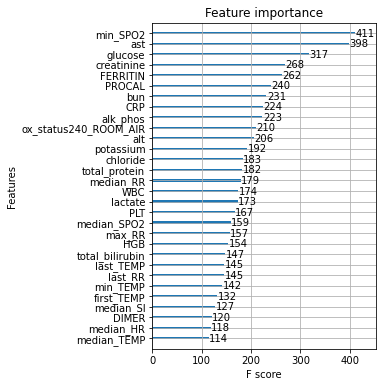

In [43]:
fig,ax=plt.subplots(1,1,figsize=(4,6))
# get preds for SkLearn
xgb.plot_importance(bst,max_num_features=30,ax=ax)
imp = bst.get_fscore() # get_score(importance_type="gain")
y_pred = bst.predict(dtest)

In [47]:
# export things of interest
if True:
    # bst.save_model(os.path.join(pdfp,'bst_200427.json'))
    import pickle
    with open(os.path.join(pdfp, 'opt_XGBmodel_200427.pkl'),'wb') as f:
        pickle.dump(bst, f, pickle.HIGHEST_PROTOCOL)
    f.close()

if True:
    # save info gain
    pd.DataFrame(imp, index=[0]).T.to_csv(os.path.join(pdfp,'optimized_info_gain.csv'))

if True: 
    # export preds and truth
    pd.DataFrame({'xgb_proba':p1,'truth':y_test['primary_outcome_yn']}).to_csv(os.path.join(pdfp,'optimized_xgb_proba.csv'))

In [30]:
# evaluate top 20 by LR
from sklearn.impute import SimpleImputer

top20 = pd.DataFrame(imp,index=range(len(imp))).loc[0,:].T.sort_values(ascending=False)[0:20].index.to_list()

X_train_scaled = X_train.loc[:,top20]
X_test_scaled = X_test.loc[:,top20]

X_train_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_train_scaled)
X_test_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_test_scaled)


# # process data
# scaler = StandardScaler()
# scaler = scaler.fit(X_train_scaled)

# # Transform both the training and testing data
# X_train_scaled = scaler.transform(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_scaled)

# no data leak
X_train_scaled = StandardScaler().fit_transform(X_train_scaled)
X_test_scaled = StandardScaler().fit_transform(X_test_scaled)

model = LogisticRegression('elasticnet', l1_ratio=0.1, 
                             solver='saga', max_iter=10000, n_jobs=-1)

start=time.time()
print('Initial model fitting')
model.fit(X_train_scaled, y_train) 
p1 = model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, p1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_pred = (p1>optimal_threshold).astype(int)
precision,recall,_ = metrics.precision_recall_curve(y_test, p1)
auprc = metrics.auc(recall, precision)
auroc = metrics.roc_auc_score(y_test,p1)
ap = metrics.average_precision_score(y_test,p1)
bs = metrics.brier_score_loss(y_test,p1)
f1 = metrics.f1_score(y_test,optimal_pred)
acc = metrics.accuracy_score(y_test,optimal_pred)
print('... trained in {:.2f}-s'.format(time.time() - start))
print('        Accuracy={:.4f}%'.format(acc))
print('        AU-ROC={:.4f}'.format(auroc))
print('        AU-PRC={:.4f}'.format(auprc))
print('        Average-precision={:.4f}'.format(ap))
print('        Brier score={:.4f}'.format(bs))
print('        F1-score={:.4f}'.format(f1))
print('        Sensitivity={:.4f}'.format(tpr[optimal_idx]))
print('        Specificity={:.4f}'.format(1-fpr[optimal_idx]))

# Odds Ratio
# np.exp(clf.coef_) # use statsmodels

Initial model fitting
... trained in 0.12-s
        Accuracy=0.8444%
        AU-ROC=0.8462
        Average-precision=0.5484
        Brier score=0.0886
        F1-score=0.5652
        Sensitivity=0.7500
        Specificity=0.8643


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [55]:
# evaluate top 20 by LR
from sklearn.impute import SimpleImputer

# run sbuset on 
min_feat = ['min_SPO2',
            'FERRITIN',
            'DIMER',
            'cxr_class_2.0',
            'ox_status240_ROOM_AIR',
            'max_RR',
            'ast',
            'alt',
            'WBC',
            'PLT',
            'CRP',
            'PROCAL']
X_train_sub = X_train.loc[:,min_feat]
X_val_sub = X_val.loc[:,min_feat]
X_test_sub = X_test.loc[:,min_feat]


X_train_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_train_sub)
X_test_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_test_sub)


# # process data
# scaler = StandardScaler()
# scaler = scaler.fit(X_train_scaled)

# # Transform both the training and testing data
# X_train_scaled = scaler.transform(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_scaled)

# no data leak
X_train_scaled = StandardScaler().fit_transform(X_train_scaled)
X_test_scaled = StandardScaler().fit_transform(X_test_scaled)

model = LogisticRegression('elasticnet', l1_ratio=0.1, 
                             solver='saga', max_iter=10000, n_jobs=-1)

start=time.time()
print('Initial model fitting')
model.fit(X_train_scaled, y_train) 
p1 = model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, p1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_pred = (p1>optimal_threshold).astype(int)
precision,recall,_ = metrics.precision_recall_curve(y_test, p1)
auprc = metrics.auc(recall, precision)
auroc = metrics.roc_auc_score(y_test,p1)
ap = metrics.average_precision_score(y_test,p1)
bs = metrics.brier_score_loss(y_test,p1)
f1 = metrics.f1_score(y_test,optimal_pred)
acc = metrics.accuracy_score(y_test,optimal_pred)
print('... trained in {:.2f}-s'.format(time.time() - start))
print('        Accuracy={:.4f}%'.format(acc))
print('        AU-ROC={:.4f}'.format(auroc))
print('        AU-PRC={:.4f}'.format(auprc))
print('        Average-precision={:.4f}'.format(ap))
print('        Brier score={:.4f}'.format(bs))
print('        F1-score={:.4f}'.format(f1))
print('        Sensitivity={:.4f}'.format(tpr[optimal_idx]))
print('        Specificity={:.4f}'.format(1-fpr[optimal_idx]))

# Odds Ratio
# np.exp(clf.coef_) # use statsmodels

Initial model fitting
... trained in 0.12-s
        Accuracy=0.7860%
        AU-ROC=0.8309
        AU-PRC=0.5081
        Average-precision=0.5140
        Brier score=0.0946
        F1-score=0.4954
        Sensitivity=0.7778
        Specificity=0.7919


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [50]:
# run sbuset on 
min_feat = ['min_SPO2',
            'FERRITIN',
            'DIMER',
            'cxr_class_2.0',
            'ox_status240_ROOM_AIR',
            'max_RR',
            'ast',
            'alt',
            'WBC',
            'PLT',
            'CRP',
            'PROCAL']
X_train_sub = X_train.loc[:,min_feat]
X_val_sub = X_val.loc[:,min_feat]
X_test_sub = X_test.loc[:,min_feat]

# train xgboost and val based off optim
start = time.time()
dtrain = xgb.DMatrix(X_train_sub, label=y_train)
dval = xgb.DMatrix(X_val_sub, label=y_val)

ratio = np.sum(y_val==0) / np.sum(y_val==1)

params = {
    # https://xgboost.readthedocs.io/en/laval/parameter.html
    'verbosity':0,

    # 'booster':gbtree (default)
    'eta':0.1, # default=0.3, set initially high, decrease later
    'max_depth':6, # default = 6 
    'min_child_weight': 1, # default = 1
    'max_delta_step':0, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
    'subsample': 0.8, # default=1
    'colsample_bytree': 1, # default=1, can set others
    'alpha':0.1, # defualt=0
    'lamda':0.1, # default=0
    'scale_pos_weight':1,
#     'scale_pos_weight':np.sum(y_val==0) / np.sum(y_val==1), # default=0; if care only about AUC, balance pos/neg weights via scale_pos_weight, see: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py, https://xgboost.readthedocs.io/en/laval/tutorials/param_tuning.html

    # learning
    'objective':'binary:logistic',
    'eval_metric':'auc',
} 

num_round = 20000
early_stopping = 500

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_round,
    evals=[(dtrain,'train'), (dval, 'val')],
    early_stopping_rounds=early_stopping
)

# other performance metrics
dtest = xgb.DMatrix(X_test_sub, label=y_test)
p1 = bst.predict(dtest, ntree_limit=bst.best_iteration)
fpr, tpr, thresholds = metrics.roc_curve(y_test, p1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_pred = (p1>optimal_threshold).astype(int)
precision,recall,_ = metrics.precision_recall_curve(y_test, p1)
auprc = metrics.auc(recall, precision)
auroc = metrics.roc_auc_score(y_test,p1)
ap = metrics.average_precision_score(y_test,p1)
bs = metrics.brier_score_loss(y_test,p1)
f1 = metrics.f1_score(y_test,optimal_pred)
acc = metrics.accuracy_score(y_test,optimal_pred)
print('... trained in {:.2f}-s'.format(time.time() - start))
print('        Accuracy={:.4f}%'.format(acc))
print('        AU-ROC={:.4f}'.format(auroc))
print('        AU-PRC={:.4f}'.format(auprc))
print('        Average-precision={:.4f}'.format(ap))
print('        Brier score={:.4f}'.format(bs))
print('        F1-score={:.4f}'.format(f1))
print('        Sensitivity={:.4f}'.format(tpr[optimal_idx]))
print('        Specificity={:.4f}'.format(1-fpr[optimal_idx]))



[0]	train-auc:0.83580	val-auc:0.69963
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 500 rounds.
[1]	train-auc:0.90132	val-auc:0.73158
[2]	train-auc:0.91952	val-auc:0.76308
[3]	train-auc:0.92127	val-auc:0.79162
[4]	train-auc:0.93329	val-auc:0.81647
[5]	train-auc:0.93505	val-auc:0.80579
[6]	train-auc:0.93298	val-auc:0.80684
[7]	train-auc:0.94196	val-auc:0.82225
[8]	train-auc:0.94847	val-auc:0.81997
[9]	train-auc:0.95854	val-auc:0.82067
[10]	train-auc:0.96712	val-auc:0.81936
[11]	train-auc:0.96796	val-auc:0.82689
[12]	train-auc:0.96962	val-auc:0.82496
[13]	train-auc:0.97090	val-auc:0.82268
[14]	train-auc:0.97490	val-auc:0.82268
[15]	train-auc:0.97729	val-auc:0.82741
[16]	train-auc:0.97679	val-auc:0.82846
[17]	train-auc:0.97990	val-auc:0.82601
[18]	train-auc:0.98123	val-auc:0.82846
[19]	train-auc:0.98378	val-auc:0.82251
[20]	train-auc:0.98469	val-auc:0.81988
[21]	train-auc:0.98562	val-auc:0.81621
[22]	train-a

In [82]:
# hyperopt 
def objective(hyperparameters):
    '''Objective function to evaluate sequential based model optimiatization via `hyperopt`.
    
    This function will be called by `hyperopt.fmin` with a value generated from `space`
    as the first arg.  It can return either a scalar-valued loss, or a dictionary.  
    
    NOTE: A returned dictionary must contain a 'status' key with a value from `STATUS_STRINGS`,  
        and a 'loss' key if the status is `STATUS_OK`.
                  
    Args: 
        hyperparameters (dict): set to optimize
        params (dict, GLOBAL): set of params in model to fix; globally set to avoid `hyperot` 
            errors.
        int_parms (list, GLOBAL): list of parameters to check to make sure 
            globally set to avoid `hyperot` errors.
        
    Returns:
        dict: with loss value for objective function specified in body and status flag
    '''
    start = timer()
    
#     ITERATION += 1
    
    if INT_PARAMS is not None:
        # Make sure parameters that need to be integers are integers
        for parameter_name in INT_PARAMS:
            hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    # merge parameters 
    trial_params = {**hyperparameters, **PARAMS}

    if False:
        # by CV
        metric = 'auc'
        xgb_optim = xgb.cv(
            trial_params, dtrain, num_boost_round=20,
            nfold=5,metrics={metric},early_stopping_rounds=10)
        best_score = xgb_optim.sort_values(by='test-{}-mean'.format(metric),ascending=False)
        best_score = best_score.iloc[0,'test-{}-mean'.format(metric)]
    else:
        # similar to eval step 
        num_round = 20
        early_stopping = 10

        model = xgb.train(
            trial_params,
            dtrain,
            num_boost_round=num_round,
            evals=[(dtrain,'train'), (dval, 'va;')],
            early_stopping_rounds=early_stopping,
            verbose_eval = num_round,
        )
        best_score = model.best_score

    # loss fx
    loss = 1 - best_score
    
    run_time = timer() - start
    
    if False :
#         # Write to the csv file ('a' means append)
#         of_connection = open(OUT_FILE, 'a')
#         writer = csv.writer(of_connection)
#         writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
#         of_connection.close()
        None

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

# fixed params
PARAMS = {
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    'verbose':0,

    'booster':'gbtree', # default='gbtree',
#     'eta':0.1, # default=0.1, set initially high, decrease later
#     'max_depth':3, # default = 0.6 
#     'min_child_weight': 1, # default = 1
#     'max_delta_step':1, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
#     'subsample': 0.8, # default=1
#     'colsample_bytree': 0.8, # default=1, can set others
#     'alpha':0.1, # defualt=0
#     'lamda':0.1, # default=0
#     'scale_pos_weight':np.sum(y_test==0) / np.sum(y_test==1), # default=0; if care only about AUC, balance pos/neg weights via scale_pos_weight, see: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py, https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

    # learning
    'objective':'binary:logistic',
    'eval_metric':'auc',
} 


# define bayesian domain
space = {'eta':hp.loguniform('eta',np.log(1e-3),np.log(0.1)),
         'max_depth':hp.quniform('max_depth',2,50,1),
         'min_child_weight':hp.quniform('min_child_weight',1,10,1),
         'max_delta_step':hp.quniform('max_delta_step',1,10,1),
         'scale_pos_weight':hp.quniform('scale_pos_weight',1,10,1),
         'subsample':hp.uniform('subsample',0.4,1),
         'colsample_bytree':hp.uniform('colsample_bytree',0.5,1),
         'alpha':hp.quniform('alpha',0.1,1,0.1),
         'lamda':hp.quniform('lamda',0,1,0.1),
        }


INT_PARAMS = ['max_depth','min_child_weight','max_delta_step']

# run sbuset on 
################################################################################################
min_feat = ['min_SPO2',
            'FERRITIN',
            'DIMER',
            'cxr_class_2.0',
            'ox_status240_ROOM_AIR',
            'max_RR',
            'ast',
            'alt',
            'WBC',
            'PLT',
            'CRP',
            'PROCAL']

X_train_sub = X_train.loc[:,min_feat]
X_val_sub = X_val.loc[:,min_feat]
X_test_sub = X_test.loc[:,min_feat]

###################################################

# train xgboost and val based off optim
start = time.time()
dtrain = xgb.DMatrix(X_train_sub, label=y_train)
dval = xgb.DMatrix(X_val_sub, label=y_val)
dtest = xgb.DMatrix(X_test_sub, label=y_test)


max_evals = 1000
ITERATION = 0

In [83]:
# run hyperopt 
trials = Trials() # record results

global ITERATION
global INT_PARAMS
global PARAMS

In [84]:

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = max_evals)

if True:
    # save trials neatly
    pd.DataFrame(trials.results).sort_values(by='loss',ascending=True).to_csv(os.path.join(pdfp,'xgb_parsi_optim.csv'))
    
print('\n best trial:\n  {}'.format(trials.best_trial))

[0]	train-auc:0.79336	va;-auc:0.65377                   

Multiple eval metrics have been passed: 'va;-auc' will be used for early stopping.


Will train until va;-auc hasn't improved in 10 rounds.  

[19]	train-auc:0.90460	va;-auc:0.80028                  

[0]	train-auc:0.83734	va;-auc:0.71066                   

Multiple eval metrics have been passed: 'va;-auc' will be used for early stopping.


Will train until va;-auc hasn't improved in 10 rounds.                  

[19]	train-auc:0.92089	va;-auc:0.80396                                  

[0]	train-auc:0.92530	va;-auc:0.71705                                              

Multiple eval metrics have been passed: 'va;-auc' will be used for early stopping. 


Will train until va;-auc hasn't improved in 10 rounds.                             

[19]	train-auc:0.98832	va;-auc:0.80387                                             

[0]	train-auc:0.86222	va;-auc:0.74926                                              

Multiple eval metrics ha

In [85]:
pd.DataFrame(trials.results).sort_values(by='loss',ascending=True).to_csv(os.path.join(pdfp,'xgb_parsi_optim.csv'))

In [86]:
hyperparam_opt = pd.DataFrame(trials.results).sort_values(by='loss',ascending=True)
hyperparam_opt

,loss,hyperparameters,iteration,train_time,status
905,0.142044,"{'alpha': 0.8, 'colsample_bytree': 0.809828623...",0,0.076788,ok
826,0.143095,"{'alpha': 0.7000000000000001, 'colsample_bytre...",0,0.373376,ok
797,0.143095,"{'alpha': 0.8, 'colsample_bytree': 0.795602758...",0,0.103542,ok
795,0.143270,"{'alpha': 0.8, 'colsample_bytree': 0.786598613...",0,0.188544,ok
815,0.146070,"{'alpha': 0.7000000000000001, 'colsample_bytre...",0,0.360482,ok
...,...,...,...,...,...
249,0.236653,"{'alpha': 0.8, 'colsample_bytree': 0.626713926...",0,0.239584,ok
64,0.245755,"{'alpha': 0.1, 'colsample_bytree': 0.658750826...",0,0.235224,ok
135,0.258358,"{'alpha': 1.0, 'colsample_bytree': 0.612016984...",0,0.686582,ok
12,0.260459,"{'alpha': 0.30000000000000004, 'colsample_bytr...",0,0.040209,ok


In [90]:
hyperparam_opt.iloc[1,1]

{'alpha': 0.7000000000000001,
 'colsample_bytree': 0.8021859484801187,
 'eta': 0.0015269939724339506,
 'lamda': 0.2,
 'max_delta_step': 9,
 'max_depth': 27,
 'min_child_weight': 1,
 'scale_pos_weight': 1.0,
 'subsample': 0.7877914369483309}

#### Optimized, parsimonious xgb

In [91]:
# run sbuset on 
min_feat = ['min_SPO2',
            'FERRITIN',
            'DIMER',
            'cxr_class_2.0',
            'ox_status240_ROOM_AIR',
            'max_RR',
            'ast',
            'alt',
            'WBC',
            'PLT',
            'CRP',
            'PROCAL']
X_train_sub = X_train.loc[:,min_feat]
X_val_sub = X_val.loc[:,min_feat]
X_test_sub = X_test.loc[:,min_feat]

# train xgboost and val based off optim
start = time.time()
dtrain = xgb.DMatrix(X_train_sub, label=y_train)
dval = xgb.DMatrix(X_val_sub, label=y_val)

ratio = np.sum(y_val==0) / np.sum(y_val==1)

params = {
    # https://xgboost.readthedocs.io/en/laval/parameter.html
    'verbosity':0,

    # 'booster':gbtree (default)
    'eta':0.001, # default=0.3, set initially high, decrease later
    'max_depth':30, # default = 6 
    'min_child_weight': 1, # default = 1
    'max_delta_step':9, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
    'subsample': 0.8, # default=1
    'colsample_bytree': 0.80, # default=1, can set others
    'alpha':0.7, # defualt=0
    'lamda':0.2, # default=0
    'scale_pos_weight':1.0,
#     'scale_pos_weight':np.sum(y_val==0) / np.sum(y_val==1), # default=0; if care only about AUC, balance pos/neg weights via scale_pos_weight, see: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py, https://xgboost.readthedocs.io/en/laval/tutorials/param_tuning.html

    # learning
    'objective':'binary:logistic',
    'eval_metric':'auc',
} 

num_round = 20000
early_stopping = 500

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_round,
    evals=[(dtrain,'train'), (dval, 'val')],
    early_stopping_rounds=early_stopping
)

# other performance metrics
dtest = xgb.DMatrix(X_test_sub, label=y_test)
p1 = bst.predict(dtest, ntree_limit=bst.best_iteration)
fpr, tpr, thresholds = metrics.roc_curve(y_test, p1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_pred = (p1>optimal_threshold).astype(int)
precision,recall,_ = metrics.precision_recall_curve(y_test, p1)
auprc = metrics.auc(recall, precision)
auroc = metrics.roc_auc_score(y_test,p1)
ap = metrics.average_precision_score(y_test,p1)
bs = metrics.brier_score_loss(y_test,p1)
f1 = metrics.f1_score(y_test,optimal_pred)
acc = metrics.accuracy_score(y_test,optimal_pred)
print('... trained in {:.2f}-s'.format(time.time() - start))
print('        Accuracy={:.4f}%'.format(acc))
print('        AU-ROC={:.4f}'.format(auroc))
print('        AU-PRC={:.4f}'.format(auprc))
print('        Average-precision={:.4f}'.format(ap))
print('        Brier score={:.4f}'.format(bs))
print('        F1-score={:.4f}'.format(f1))
print('        Sensitivity={:.4f}'.format(tpr[optimal_idx]))
print('        Specificity={:.4f}'.format(1-fpr[optimal_idx]))



[0]	train-auc:0.78663	val-auc:0.67390
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 500 rounds.
[1]	train-auc:0.78895	val-auc:0.69027
[2]	train-auc:0.86689	val-auc:0.81078
[3]	train-auc:0.90317	val-auc:0.84089
[4]	train-auc:0.90631	val-auc:0.84518
[5]	train-auc:0.90884	val-auc:0.84588
[6]	train-auc:0.90702	val-auc:0.84745
[7]	train-auc:0.90943	val-auc:0.84483
[8]	train-auc:0.90736	val-auc:0.84325
[9]	train-auc:0.91280	val-auc:0.84229
[10]	train-auc:0.91435	val-auc:0.84019
[11]	train-auc:0.92016	val-auc:0.83415
[12]	train-auc:0.91926	val-auc:0.83362
[13]	train-auc:0.92116	val-auc:0.83275
[14]	train-auc:0.92659	val-auc:0.83205
[15]	train-auc:0.92578	val-auc:0.83319
[16]	train-auc:0.92466	val-auc:0.83266
[17]	train-auc:0.92483	val-auc:0.83319
[18]	train-auc:0.92548	val-auc:0.82881
[19]	train-auc:0.92440	val-auc:0.82934
[20]	train-auc:0.92517	val-auc:0.82689
[21]	train-auc:0.92505	val-auc:0.83529
[22]	train-a

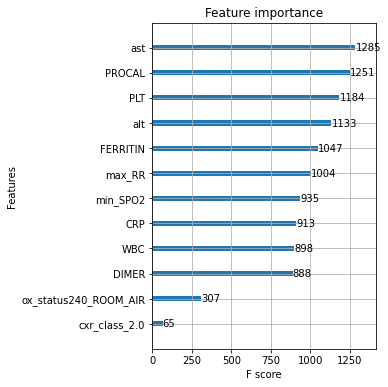

In [92]:
fig,ax=plt.subplots(1,1,figsize=(4,6))
# get preds for SkLearn
xgb.plot_importance(bst,max_num_features=30,ax=ax)
imp = bst.get_fscore() # get_score(importance_type="gain")
y_pred = bst.predict(dtest)



In [93]:

# export things of interest
if True:
    # bst.save_model(os.path.join(pdfp,'bst_200427.json'))
    import pickle
    with open(os.path.join(pdfp, 'ADHfav_XGBparsi_model_200427.pkl'),'wb') as f:
        pickle.dump(bst, f, pickle.HIGHEST_PROTOCOL)
    f.close()

if False:
    # save info gain
    pd.DataFrame(imp, index=[0]).T.to_csv(os.path.join(pdfp,'optimized_XGBparsi_info_gain.csv'))

if True: 
    # export preds and truth
    pd.DataFrame({'xgb_proba':p1,'truth':y_test['primary_outcome_yn']}).to_csv(os.path.join(pdfp,'optimized_XGBparsi_proba.csv'))

In [ ]:
def calibration_plot(y_true, y_prob, n_bins=10, strategy='uniform', name='XGB'):
#     recursion_limit = sys.getrecursionlimit()
    prob_true, prob_pred = calibration_curve(y_true.astype(float), y_prob, n_bins=n_bins, strategy=strategy)
    
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot(prob_pred, prob_true, 's-', label=name)
    ax2.hist(y_prob, range=(0, 1), bins=n_bins, label=name, histtype='step', lw=2)

    ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')

    ax1.set_xlabel('Fraction of positives (Predicted)')
    ax1.set_ylabel('Fraction of positives (Actual)')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='lower right')
    ax1.set_title('Calibration Plots (Reliability Curve)')

    ax2.set_xlabel('Predicted scores')
    ax2.set_ylabel('Count')
    ax1.set_title('Histogram of Predicted Scores')
    ax2.legend(loc='upper center', ncol=2)
        


In [ ]:
calibration_plot(y_test, 
                 bst.predict(dtest, ntree_limit=bst.best_iteration), 
                 n_bins=10, name='XGB')

In [ ]:
calibration_plot(y_test, 
                 model.predict_proba(X_test_scaled)[:,1], 
                 n_bins=10, name='parsiLR')

In [ ]:
model = bst
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, max_display=30)

In [ ]:
shap.dependence_plot("ast", shap_values, X_test)

## dev

## quality control

In [ ]:
ed_df = load_csv(os.path.join(base_path,os.path.join('ed_extra','ed_extra2.csv')))
ed_df = ed_df.reset_index()
# ed_df = ed_df.rename(columns={'PatientDurableKey':'person_id',
#                             'EncounterKey':'visit_occurrence_id',
#                             'Name':'chief_complaint'})
demo_df = load_csv(os.path.join(base_path,os.path.join('demographics','demo.csv')))

def create_base_df(demo, ed_extra, outcomes):
    """
    from AT
    """
    #select desired columns from each datafraome
    outcomes = outcomes[['visit_occurrence_id', 'exflag_yn', 'primary_outcome_yn']]
    ed_extra = ed_extra[['PatientDurableKey', 'EncounterKey']]
    demo = demo[['age_years', 'person_id']]
    #join columns together
    base = (outcomes
          .merge(ed_extra, right_on='EncounterKey', left_on='visit_occurrence_id')
          .merge(demo, left_on='PatientDurableKey', right_on='person_id'))
    base = base.query('exflag_yn==0 & age_years>17')
    base = base[['visit_occurrence_id', 'primary_outcome_yn']]
    base = base.drop_duplicates(subset=('visit_occurrence_id'))
    return base 
#%%
base = create_base_df(demo_df, ed_df, outcomes_df)
base.head()
#%%
base['primary_outcome_yn'].value_counts()

## to develop

In [ ]:
# check calculated scores
fig,ax=plt.subplots(1,2,figsize=(6,2))
sns.distplot(df['curb65'],kde=False,ax=ax[0])
sns.distplot(df['qSOFA'],kde=False,ax=ax[1])

In [ ]:
# check vitals 
x.groupby('vital_name', as_index=False).agg({'value_source_value':['median','min','max']})
fig = plt.figure(figsize=(10,9))
for i,vital in enumerate(x['vital_name'].unique()):
    ax = fig.add_subplot(3,3,i+1)
    try:
        sns.kdeplot(x.loc[x['vital_name']==vital,'value_source_value'],
                    shade=True,
                    color=sns.color_palette('muted',9)[i], ax=ax)
    except RuntimeError:
        print('Problem with {}'.format(vital))
        sns.distplot(x.loc[x['vital_name']==vital,'value_source_value'],
                        kde=False, label=vital,
                        color=sns.color_palette('muted',9)[i], ax=ax)
    ax.legend().set_visible(False)
    ax.set_title(vital)
fig.tight_layout()

In [ ]:
def test_lab_missing(labs, base):
    missing_df = pd.DataFrame()
    for time_interval in [60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720]:
        col_name = 'minutes' + str(time_interval)
        lab_test = preprocess_labs(labs, base, time_interval=time_interval)
        missing_df[col_name] = lab_test.isna().mean().round(4) * 100
    return missing_df
#%%
missing_df = test_lab_missing(df_labs, df_test[['visit_occurrence_id']])